# How close is close enough?

This is based on [Greg Wilson's post on testing](http://software-carpentry.org/blog/2014/10/why-we-dont-teach-testing.html), but avoids the big, difficult questions. Instead I focus on his comment about "close enough" in [the full phugoid model notebook](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb).

See also [this page from NASA on grid convergence](http://www.grc.nasa.gov/WWW/wind/valid/tutorial/spatconv.html). Also [this paper by Liu](http://ocw.mit.edu/courses/mathematics/18-304-undergraduate-seminar-in-discrete-mathematics-spring-2006/projects/xtrpltn_liu_xpnd.pdf), which is rather mathematical, on Richardson extrapolation and its extensions.

## Round off

Let's start by reminding ourselves how round-off error comes in to numerical calculations. As an example, remember that $\sin(2\pi) = 0$, and in fact $\sin(2 k \pi)=0$ for any integer $k$.

We'll use `numpy` for the calculations.

In [44]:
%matplotlib notebook
import numpy
from matplotlib import pyplot
from numpy import pi, sin, arange

In [45]:
ks = arange(10)
sins = sin(2.0*ks*pi)
for k, s in zip(ks, sins):
    print("sin(2 k pi) evaluates to {:.3g} when k={}.".format(s, k))
print("Adding these all up (result should be 0) we get {}.".format(sins.sum()))

sin(2 k pi) evaluates to 0 when k=0.
sin(2 k pi) evaluates to -2.45e-16 when k=1.
sin(2 k pi) evaluates to -4.9e-16 when k=2.
sin(2 k pi) evaluates to -7.35e-16 when k=3.
sin(2 k pi) evaluates to -9.8e-16 when k=4.
sin(2 k pi) evaluates to -1.22e-15 when k=5.
sin(2 k pi) evaluates to -1.47e-15 when k=6.
sin(2 k pi) evaluates to -1.71e-15 when k=7.
sin(2 k pi) evaluates to -1.96e-15 when k=8.
sin(2 k pi) evaluates to -2.2e-15 when k=9.
Adding these all up (result should be 0) we get -1.1021821192326179e-14.


So we had ten different numerical calculations with errors between $0$ and $\sim 2 \times 10^{-15}$, which when combined lead to a total error $\sim 10^{-14}$. This illustrates the standard result:

Summing $N$ calculations with errors $\delta_i$, where $\delta_i \le \delta = \max_i \delta_i$, leads to a total error ${\cal E}$ which is bounded by ${\cal E} \le N \delta$.

## Going beyond sums

We'll use a very simple initial value problem (as the calculations are faster):

$$
\begin{equation}
  y' = -\sin(x), \qquad y(0) = 1
\end{equation}
$$

which has the solution $y = \cos(x)$. We'll solve this using Euler's method, as in the original notebook:

$$
\begin{equation}
  y_{n+1} = y_n - h \sin(x_n), \qquad y_0 = 1
\end{equation}
$$

where $h$ is the grid spacing and $x_n = n h$, with $n = 0, 1, \dots$ the grid step.

In [46]:
def simple_euler(h, N):
    """
    Solve the problem y' = -sin(x), y(0) = 1 using Euler's method.
    
    Parameters
    ----------
    
    h : float
        Grid spacing
    N : int
        Number of steps
        
    Returns
    -------
    
    Y : float
        y(Nh) as approximated by Euler's method
    """
    
    # Initial data
    Y = 1.0
    x = 0.0
    for n in range(N):
        Y -= h*sin(x)
        x += h
    
    return Y

So, how good is this method? Check by comparing against the exact solution when $X=1$.

In [47]:
X = 1.0
N_all = numpy.array([2**i for i in range(3, 20)])
h_all = X / N_all
Y_exact = numpy.cos(X)
Y_approx = numpy.zeros_like(h_all)
Y_errors = numpy.zeros_like(h_all)
for i, N in enumerate(N_all):
    h = h_all[i]
    Y_approx[i] = simple_euler(h, N)
    Y_errors[i] = numpy.abs(Y_approx[i] - Y_exact)

<IPython.core.display.Javascript object>


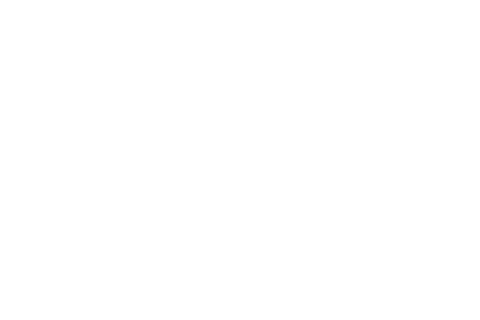

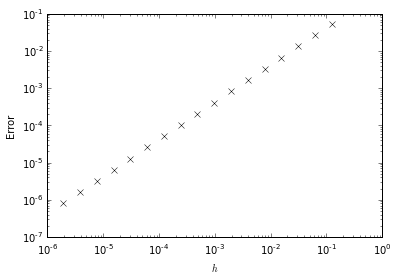

In [48]:
pyplot.loglog(h_all, Y_errors, 'kx')
pyplot.xlabel(r'$h$')
pyplot.ylabel('Error');

So, what should we expect? If implemented correctly, we know that Euler's method behaves as $\text{Error} \propto h + {\cal O}(h^2)$. As a first guess we drop the higher order terms, giving $\text{Error} = c_1 h$, or $\log(\text{Error}) = \log(h) + \text{const}$. 

We can then compute the best fit line through the data and see if it matches this assumption.

<IPython.core.display.Javascript object>


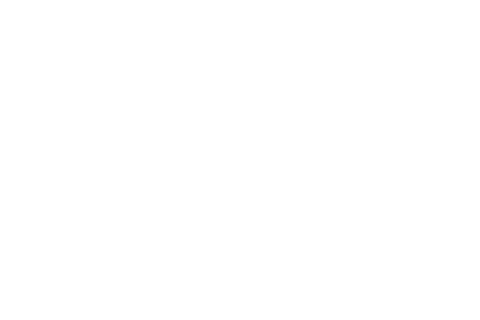

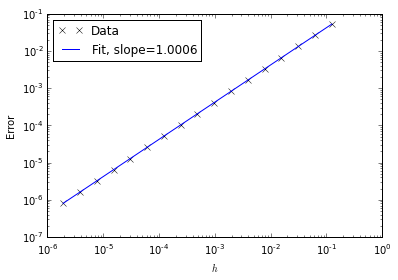

In [49]:
simple_p = numpy.polyfit(numpy.log(h_all), numpy.log(Y_errors), 1)
pyplot.loglog(h_all, Y_errors, 'kx', label='Data')
pyplot.loglog(h_all, numpy.exp(simple_p[1])*h_all**(simple_p[0]), 'b-', label='Fit, slope={:.4f}'.format(simple_p[0]))
pyplot.legend(loc='upper left')
pyplot.xlabel(r'$h$')
pyplot.ylabel('Error');

So, the best fit line matches the expected slope (1) to better than $0.3\%$. Is this good enough?

First, let's do a sanity check. Why do we believe that the slope shouldn't be *exactly* $1$? It's because of our assumption: that $\text{Error} \propto h + {\cal O}(h^2)$, and that we could ignore the higher order terms. The assumption that the error takes this form is essentially saying that we've implemented the algorithm correctly (which is what we're trying to check!). The assumption that we can ignore the higher order terms is more reasonable when $h$ is small, like $10^{-5}$, but not when $h \sim 10^{-1}$. So the slope should get closer to $1$ if we ignore the results for larger $h$. Let's do that calculation:

In [50]:
for i in range(1, len(Y_errors)-2):
    partial_p = numpy.polyfit(numpy.log(h_all[i:]), numpy.log(Y_errors[i:]), 1)
    print("The slope, when ignoring {} entries, is {:.6f}. (slope-1)={:.4g}".format(i+1, partial_p[0], partial_p[0]-1.0))

The slope, when ignoring 2 entries, is 1.000313. (slope-1)=0.0003133
The slope, when ignoring 3 entries, is 1.000176. (slope-1)=0.0001758
The slope, when ignoring 4 entries, is 1.000099. (slope-1)=9.92e-05
The slope, when ignoring 5 entries, is 1.000056. (slope-1)=5.638e-05
The slope, when ignoring 6 entries, is 1.000032. (slope-1)=3.23e-05
The slope, when ignoring 7 entries, is 1.000019. (slope-1)=1.867e-05
The slope, when ignoring 8 entries, is 1.000011. (slope-1)=1.09e-05
The slope, when ignoring 9 entries, is 1.000006. (slope-1)=6.439e-06
The slope, when ignoring 10 entries, is 1.000004. (slope-1)=3.851e-06
The slope, when ignoring 11 entries, is 1.000002. (slope-1)=2.336e-06
The slope, when ignoring 12 entries, is 1.000001. (slope-1)=1.439e-06
The slope, when ignoring 13 entries, is 1.000001. (slope-1)=9.026e-07
The slope, when ignoring 14 entries, is 1.000001. (slope-1)=5.777e-07
The slope, when ignoring 15 entries, is 1.000000. (slope-1)=3.79e-07


That's good news. We could just fit the final few entries to get closer to the expected slope, but we're still not answering how close is "close enough"

One additional question that is quite important. What's the effect of changing how far we integrate, by changing $X$? Let's make $X$ smaller.

In [51]:
X = 1.0e-5
h_all = X / N_all
Y_exact_short = numpy.cos(X)
Y_approx_short = numpy.zeros_like(h_all)
Y_errors_short = numpy.zeros_like(h_all)
for i, N in enumerate(N_all):
    h = h_all[i]
    Y_approx_short[i] = simple_euler(h, N)
    Y_errors_short[i] = numpy.abs(Y_approx_short[i] - Y_exact_short)

<IPython.core.display.Javascript object>


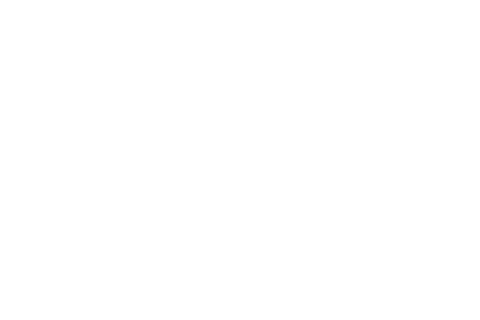

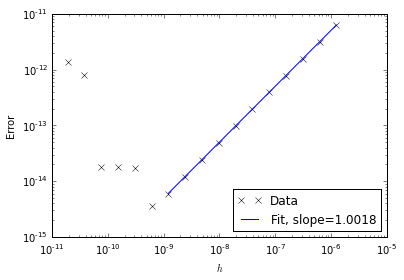

In [52]:
simple_p_short = numpy.polyfit(numpy.log(h_all[:-6]), numpy.log(Y_errors_short[:-6]), 1)
pyplot.loglog(h_all, Y_errors_short, 'kx', label='Data')
pyplot.loglog(h_all[:-6], numpy.exp(simple_p_short[1])*h_all[:-6]**(simple_p_short[0]), 'b-', label='Fit, slope={:.4f}'.format(simple_p_short[0]))
pyplot.legend(loc='lower right')
pyplot.xlabel(r'$h$')
pyplot.ylabel('Error');

We see that the algorithm converges as expected until $h$ is so small that floating point round-off errors become important. Below that point the error of each individual step does not depend on $h$ (as the truncation error of the algorithm is less than floating point round-off) but is essentially random, and has the magnitude of floating point round-off. These individual errors will then add up. To check this, we can look at the contribution from floating point errors at each step:

<IPython.core.display.Javascript object>


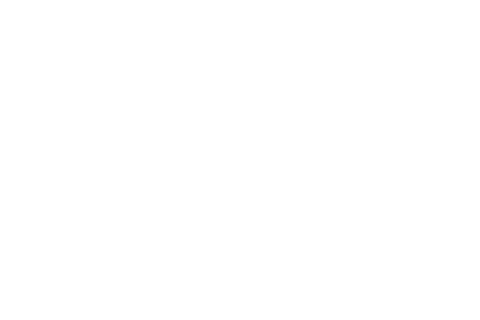

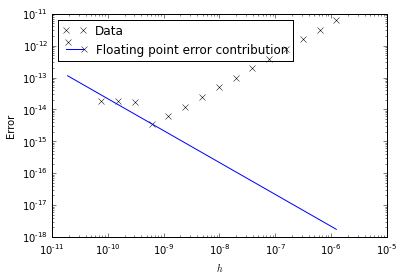

In [53]:
floating_error_step = numpy.spacing(1.0e-3)
floating_error = floating_error_step * N_all
pyplot.loglog(h_all, Y_errors_short, 'kx', label='Data')
pyplot.loglog(h_all, floating_error, 'b-', label='Floating point error contribution')
pyplot.legend(loc='upper left')
pyplot.xlabel(r'$h$')
pyplot.ylabel('Error');

Let's check the truncation error instead. First, redo the analysis to find out *exactly* what that should look like.

In [54]:
import sympy
sympy.init_printing()
y = sympy.Function('y')
f = sympy.Function('f')
x, h, b= sympy.symbols('x, h, b')
y_n_p_1 = y(x) + h * f(x, y(x))

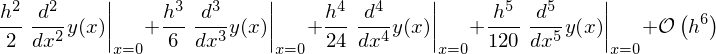

In [55]:
truncation_error = sympy.series(y(h),h)-y_n_p_1.subs(x, 0)
truncation_error = truncation_error.subs(f(0, y(0)), sympy.Subs(sympy.Derivative(y(x), x),(x,),(0,)))
truncation_error

So the truncation error should be the sum of each of these terms: for $h$ sufficiently small the higher order terms should have no effect at all. We can check, using that the derivatives of $\cos(x)$ at $x=0$ are alternatively $1$ and $0$ in magnitude:

In [56]:
h_truncation = numpy.array([2**(-i) for i in range(4,20)])
Y_truncation_error = numpy.zeros_like(h_truncation)
Y_expected_truncation_error = numpy.zeros_like(h_truncation)
for i, h in enumerate(h_truncation):
    Y_truncation_error[i] = numpy.abs(simple_euler(h, 1) - numpy.cos(h))
    Y_expected_truncation_error[i] = h**2/2.0 - h**4/24.0 + h**6/720.0 - h**8/40320.

<IPython.core.display.Javascript object>


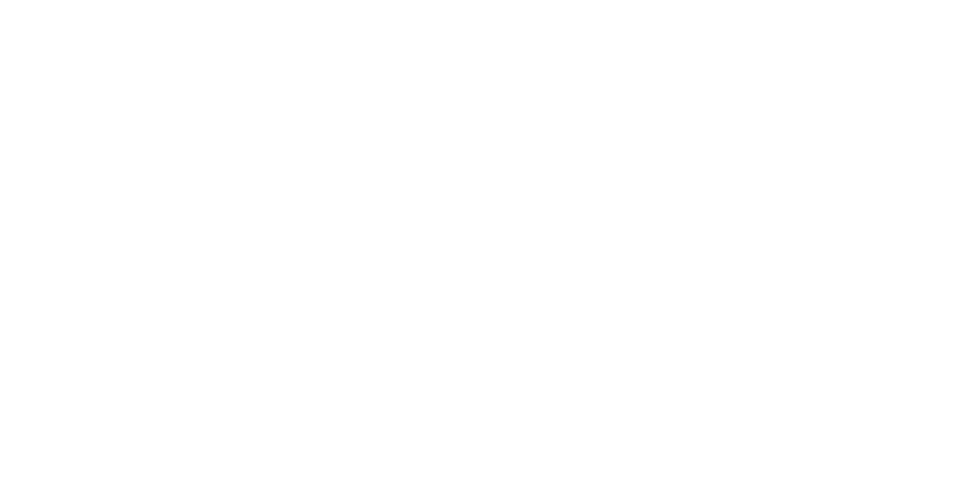

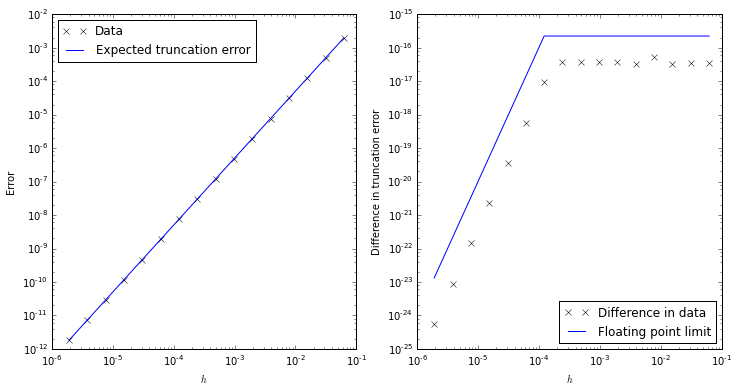

In [57]:
fig=pyplot.figure(figsize=(12,6))
ax1=fig.add_subplot(121)
ax1.loglog(h_truncation, Y_truncation_error, 'kx', label='Data')
ax1.loglog(h_truncation, Y_expected_truncation_error, 'b-', label='Expected truncation error')
ax1.legend(loc='upper left')
ax1.set_xlabel(r'$h$')
ax1.set_ylabel('Error');
ax2=fig.add_subplot(122)
ax2.loglog(h_truncation, numpy.abs(Y_truncation_error-Y_expected_truncation_error), 'kx', label='Difference in data')
ax2.loglog(h_truncation, numpy.minimum(numpy.spacing(1.0),numpy.spacing(h_truncation**4)/numpy.spacing(1.0)), 'b-', label='Floating point limit')
ax2.legend(loc='lower right')
ax2.set_xlabel(r'$h$')
ax2.set_ylabel('Difference in truncation error');

We note that for $h$ sufficiently small the limitation is no longer the floating point error, but instead falls off like $h^4$.  This is (likely) because the $h^4$ term is not correctly captured in one of the calculations (as $h \lesssim 10^{-4}$ we have $h^4$ less than floating point round-off). If we went to larger $h$ we would again find that the "expected truncation error" doesn't match, as more terms in the expansion would be needed.

## Richardson extrapolation

Let's go back to a different application of the "close enough" issue. What do we actually want to use the convergence plot *for*?

At its heart, Euler's method is approximating the exact solution $y(x)$ at a point $x=X$ to some degree of accuracy. We care about two things: the exact value $y(X)$ and the error made in approximating it, $E_h$. As, in general, we don't know the exact solution, we can't know the value of the error. However, we can show how it depends on the grid step $h$, and from that we can approximately calculate how big it is for any system. That is, we can put *error bars* on our answer. For those that like the "computation as experiment" analogy, this is exactly what we should be doing.

To do this, we use *Richardson extrapolation*. We compute the solution with Euler's method twice, to get $y^{(h)}$ and $y^{(2h)}$: two approximations to the solution $y(X)$ computed with different (but related) step lengths. Using the error analysis as a basis, we *assume* that

$$
\begin{equation}
  y(X) = y^{(h)} + C h.
\end{equation}
$$

Given the two calculations $y^{(h)}$ and $y^{(2h)}$, and our assumption, we can solve for the exact solution $y(X)$ and for the error $C h$ to find

$$
\begin{equation}
  y(X) = 2 y^{(h)} - y^{(2h)}, \qquad C h = y^{(2h)} - y^{(h)}.
\end{equation}
$$

So, we can go back to our original problem and look at $y(1)$, the Richardson extrapolated "exact" solution, and the error bound that results.

In [58]:
X = 1.0
N_all = numpy.array([2**i for i in range(3, 20)])
h_all = X / N_all
Y_richardson = numpy.zeros_like(Y_approx)
Y_richardson_error = numpy.zeros_like(Y_approx)
for i in range(1, len(h_all)):
    Y_richardson[i] = 2.0*Y_approx[i] - Y_approx[i-1]
    Y_richardson_error[i] = abs(Y_approx[i-1] - Y_approx[i])

<IPython.core.display.Javascript object>


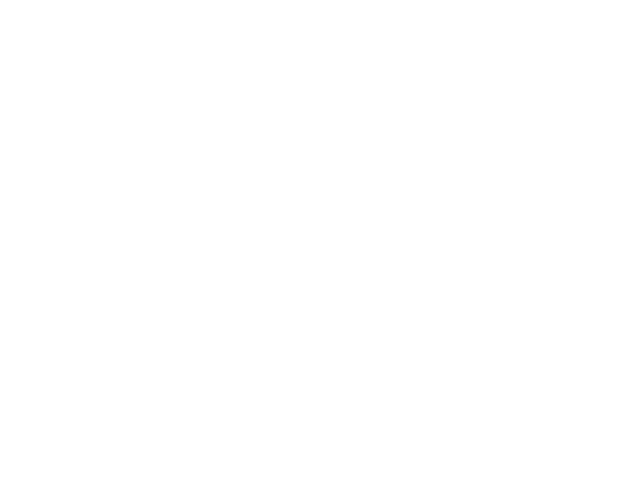

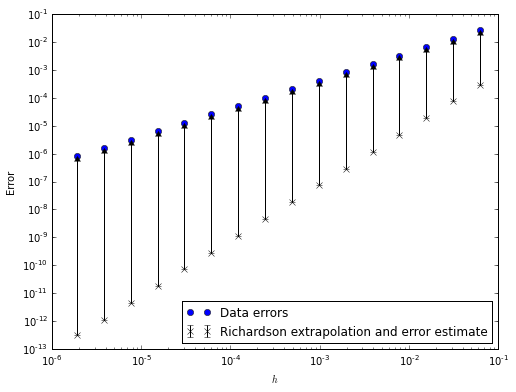

In [59]:
fig=pyplot.figure(figsize=(8,6))
ax1=fig.add_subplot(111)
ax1.loglog(h_all[1:], Y_errors[1:], 'bo', label='Data errors')
ax1.set_xscale("log", nonposx='clip')
ax1.set_yscale("log", nonposy='clip')
ax1.errorbar(h_all[1:], numpy.abs(Y_exact - Y_richardson[1:]), yerr=Y_richardson_error[1:], 
             lolims=True, marker='x', color='k', ls='None', label='Richardson extrapolation and error estimate')
ax1.legend(loc='lower right')
ax1.set_xlabel(r'$h$')
ax1.set_ylabel('Error');

We see that the error bar found from Richardson extrapolation pretty much matches up with the error in the original calculation, as expected. So, using the two best results (i.e., those with the highest resolution, or smallest $h$) we can say that

In [60]:
print("y(1) = {} ± {}.".format(Y_richardson[-1], Y_richardson_error[-1]))

y(1) = 0.5403023058678328 ± 8.024897067970826e-07.


However, this analysis is all based on the *assumption* that the error is exactly proportional to $h$. We know this isn't true; we're neglecting higher order terms. We see this because we measure a convergence rate that isn't exactly $1$. So we need a different model for the behaviour of our algorithm. We could add more terms to the error (as expected), but this leads to more parameters to fit, which is bad (["with four parameters I can fit an elephant"](http://en.wikiquote.org/wiki/John_von_Neumann) and so on). Instead we keep a single error term, but write $y(X) = y^{(h)} + C h^s$ where $s$ is measured from the data (above we have $1.0006$). This leads to the Richardson extrapolation formulas

$$
\begin{equation}
  y(X) = \frac{2^s y^{(h)} - y^{(2h)}}{2^s - 1}, \qquad C h = \frac{y^{(2h)} - y^{(h)}}{2^s - 1}.
\end{equation}
$$

Applying this assumption to the data, we get a new set of error bars:

In [61]:
Y_richardson_measured_s = numpy.zeros_like(Y_approx)
Y_richardson_error_measured_s = numpy.zeros_like(Y_approx)
for i in range(1, len(h_all)):
    Y_richardson_measured_s[i] = (2.0**(simple_p[0])*Y_approx[i] - Y_approx[i-1])/(2.0**(simple_p[0])-1.0)
    Y_richardson_error_measured_s[i] = abs(Y_approx[i-1] - Y_approx[i])/(2.0**(simple_p[0])-1.0)
print("y(1) = {} ± {}.".format(Y_richardson_measured_s[-1], Y_richardson_error_measured_s[-1]))
print("Difference between predicted exact values is {:.4g}.".format(abs(Y_richardson[-1]-Y_richardson_measured_s[-1])))

y(1) = 0.5403023064917923 ± 8.018657471901381e-07.
Difference between predicted exact values is 6.24e-10.


You have to look quite hard to see the difference. But the key point here is that the two exact values predicted by the different assumptions lie within each other's error bars.

Let's repeat this analysis using the data from the phugoid problem sheet. In this case we have a more complex system, a longer integration error (leading to a larger error), worse resolution (leading to a larger error), fewer data points, and no knowledge of the exact solution. However, we are still using Euler's method, so we expect the same behaviour for the error.

I explicitly give the values of the errors here rather than the code, to save time. I modified the range of values considered to

`dt_values = numpy.array([0.1*2**(-i) for i in range(8)])`

to ensure that nice factor 2 between each resolution. I then computed the differences between each using the `get_diffgrid` function, and did the best fit line getting a slope of $1.21154575$ with the data below:

In [62]:
dt_values = numpy.array([ 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625])
diffgrid = numpy.array([ 25.4562819, 10.52418949, 4.75647465, 2.20894037, 1.01024986, 0.42865587, 0.14217568])
s = 1.21154575

Y_richardson_phugoid = numpy.zeros_like(diffgrid)
Y_richardson_phugoid_error = numpy.zeros_like(diffgrid)
Y_richardson_phugoid_measured_s = numpy.zeros_like(diffgrid)
Y_richardson_phugoid_error_measured_s = numpy.zeros_like(diffgrid)
for i in range(1, len(diffgrid)):
    Y_richardson_phugoid[i] = (2.0*diffgrid[i] - diffgrid[i-1])
    Y_richardson_phugoid_measured_s[i] = (2.0**(s)*diffgrid[i] - diffgrid[i-1])/(2.0**(s)-1.0)
    Y_richardson_phugoid_error[i] = abs(diffgrid[i-1] - diffgrid[i])
    Y_richardson_phugoid_error_measured_s[i] = abs(diffgrid[i-1] - diffgrid[i])/(2.0**(s)-1.0)
print("Phugoid limit, standard assumption = {} ± {}.".format(Y_richardson_phugoid[-1], Y_richardson_phugoid_error[-1]))
print("Phugoid limit, measured slope = {} ± {}.".format(Y_richardson_phugoid_measured_s[-1], Y_richardson_phugoid_error_measured_s[-1]))
print("Difference between predicted limits is {:.4g}.".format(abs(Y_richardson_phugoid[-1]-Y_richardson_phugoid_measured_s[-1])))

Phugoid limit, standard assumption = -0.14430451 ± 0.28648019.
Phugoid limit, measured slope = -0.07553820347702735 ± 0.21771388347702736.
Difference between predicted limits is 0.06877.


We see the errors are much larger, but that the difference between the limiting values is within the predicted error bars of either result. Therefore the assumption that the algorithm is behaving as the idealized Euler's method does is *close enough* that the predicted result lies within the predicted error bars.

So how close *is* close enough? We need 

$$
\begin{equation}
\left| \frac{2^s y^{(h)} - y^{(2h)}}{2^s - 1} - \left( 2 y^{(h)} - y^{(2h)} \right) \right| \le \left| \frac{y^{(2h)} - y^{(h)}}{2^s - 1} \right|.
\end{equation}
$$

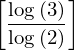

In [63]:
yh, y2h, s = sympy.symbols('y^h, y^{2h}, s')
Eq1 = sympy.Eq((2**s*yh-y2h)/(2**s-1)-(2*yh-y2h) , (y2h-yh)/(2**s-1))
sympy.solve(Eq1, s)

There's another root to check:

In [64]:
Eq2 = sympy.Eq((2**s*yh-y2h)/(2**s-1)-(2*yh-y2h) , -(y2h-yh)/(2**s-1))
sympy.solve(Eq2, s)

So the threshold is $s = \log(3)/\log(2) \simeq 1.585$.

But there's also the other interval, for which we need

$$
\begin{equation}
\left| \frac{2^s y^{(h)} - y^{(2h)}}{2^s - 1} - \left( 2 y^{(h)} - y^{(2h)} \right) \right| \le \left| y^{(2h)} - y^{(h)} \right|.
\end{equation}
$$

In [65]:
Eq3 = sympy.Eq((2**s*yh-y2h)/(2**s-1)-(2*yh-y2h) , (y2h-yh))
sympy.solve(Eq3, s)

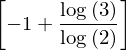

In [66]:
Eq4 = sympy.Eq((2**s*yh-y2h)/(2**s-1)-(2*yh-y2h) , -(y2h-yh))
sympy.solve(Eq4, s)

This gives the lower bound of $\simeq 0.585$.

This is very specific to Euler's method. What if we're using a better method with convergence rate $s_e$, so that the idealized behaviour of the algorithm is $y(X) = y^{(h)} + C h^{s_e}$? In that case, if we measure a convergence rate of $s_m$, then the results are close enough when

$$
\begin{equation}
\left| \frac{2^{s_e} y^{(h)} - y^{(2h)}}{2^{s_e} - 1} - \frac{2^{s_m} y^{(h)} - y^{(2h)}}{2^{s_m} - 1} \right| \le \left| \frac{y^{(2h)} - y^{(h)}}{2^{s_e} - 1} \right|
\end{equation}
$$

and

$$
\begin{equation}
\left| \frac{2^{s_e} y^{(h)} - y^{(2h)}}{2^{s_e} - 1} - \frac{2^{s_m} y^{(h)} - y^{(2h)}}{2^{s_m} - 1} \right| \le \left| \frac{y^{(2h)} - y^{(h)}}{2^{s_m} - 1} \right| .
\end{equation}
$$

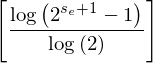

In [67]:
yh, y2h, se, sm = sympy.symbols('y^h, y^{2h}, s_e, s_m')
Eq5 = sympy.Eq((2**sm*yh-y2h)/(2**sm-1)-(2**se*yh-y2h)/(2**se-1) , (y2h-yh)/(2**sm-1))
sympy.solve(Eq5, sm)

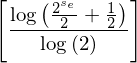

In [68]:
Eq6 = sympy.Eq((2**sm*yh-y2h)/(2**sm-1)-(2**se*yh-y2h)/(2**se-1) , -(y2h-yh)/(2**se-1))
sympy.solve(Eq6, sm)

So we can see how the bound changes with increased accuracy of the ideal algorithm:

<IPython.core.display.Javascript object>


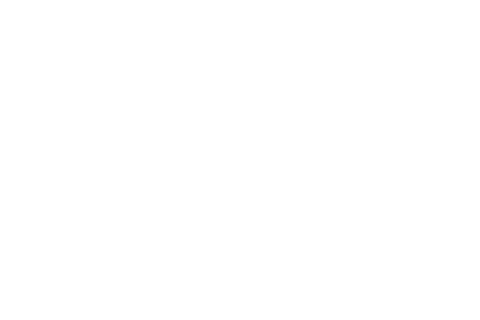

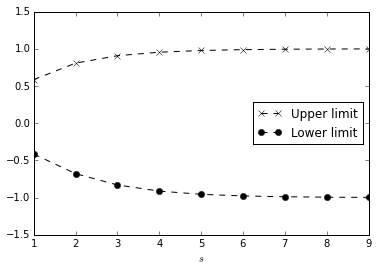

In [69]:
s = numpy.arange(1,10)
upper_limit = numpy.log(2.0**(s+1)-1.0)/numpy.log(2.0)
lower_limit = numpy.log(2.0**(s-1)+0.5)/numpy.log(2.0)
pyplot.plot(s, upper_limit-s, 'kx--', label='Upper limit')
pyplot.plot(s, lower_limit-s, 'ko--', label='Lower limit')
pyplot.xlabel(r'$s$')
pyplot.ylim(-1.5, 1.5)
pyplot.legend(loc='center right');

For algorithms where the accuracy is high (I'd say $s \ge 6$) then the measured convergence rate is *close enough* if $s_m \in s_e \pm 1$!

## Setup

The problem that's at hand is a numerical method, in this case Euler's method, that's solving a differential equation

$$
\begin{equation}
  y'(x) = f(x, y), \qquad y(0) = y_0.
\end{equation}
$$

This method uses small steps $h \ll 1$ to approximate the solution $y(x)$ from $x=0$ to some point $X > 0$. Formal analysis shows that, under certain weak assumptions (essentially about the smoothness of $f$, particularly at $x=0$), the error of the method is first order. What this means is that the difference between the numerical solution $\hat{y}(X)$ and the true solution $y(X)$ is proportional to $h$, for sufficiently small $h$. We call this the error $E(h)$. This suggests that, in the limit as $h$ goes to zero, the error will go to zero, and the numerical solution will match the true solution.

Note immediately that most of the time, as in the phugoid model, we don't know the exact solution so can't measure the error. Instead we can measure *self convergence* by checking that the numerical solution converges to *something*. In other words, we want to check that $\hat{y}(X) = Y(X) + {\cal O}(h)$, so that in the limit as $h$ goes to zero we get a single, unique solution. Further analysis is needed to show that this is the *true* solution (essentially we need to impose *consistency* of the difference equation to the differential equation), which we won't worry about here. To do this we define the *difference*

$$
  D(h) = | \hat{y}_h(X) - \hat{y}_{ref}(X) |.
$$

Here $\hat{y}_{ref}$ is some reference solution, assumed to be computed at high accuracy.

With this setup, we're measuring convergence by checking that $D(h) = {\cal O}(h)$: the solution converges to something fixed if the difference converges to zero with $h$. Again, for Euler's method, a formal analysis shows that

$$
\begin{equation}
  D(h) = a h + {\cal O}(h^2)
\end{equation}
$$

where $a$ is some constant.

## The problem

It might be that we've incorrectly implemented Euler's method and it doesn't converge in the expected fashion. There are three possibilities.

### Unstable, inconsistent

In this case we're expecting the solution doesn't converge to a limit, so that

$$
\begin{equation}
  D(h) = \alpha h^{-s} + {\cal O}(h^{-s+1}).
\end{equation}
$$

In this case the difference diverges as $h$ gets smaller: this corresponds to the error diverging. This is really bad, and the error should be really obvious. Later we'll see what bounds we can put on the coefficients given the data.

### Stable, inconsistent

This is a slightly odd case. If we had

$$
\begin{equation}
  E(h) = E_0 + \alpha h + {\cal O}(h^2)
\end{equation}
$$

then the interpretation is straightforward: the algorithm is wrong (as $h$ goes to zero the error does not), but it is converging to something. 

If, on the other hand, we have

$$
\begin{equation}
  D(h) = D_0 + \alpha h + {\cal O}(h^2)
\end{equation}
$$

the the *difference* between two numerical solutions is not going to zero with $h$. This is not impossible, but would be really odd at the continuum level. However, there is one important point that we cannot ignore: the limitations of floating point arithmetic.

#### Floating point effects

We know that we can't perfectly represent a real number on a computer, leading to an intrinsic error when representing a number $z$ which we'll call $\delta_z$. We have to count on the worst case, so that adding $N$ numbers $\{ z_i \}$ leads to a total error of $N \delta$ where $\delta = \max_i \delta_{z_i}$.

However, in our case it's even worse than that. Each step of using the Euler method introduces an error, which is compounded by the previous errors: the numerical data we use to go from $x$ to $x + h$ is already wrong thanks to the earlier steps in the method. We can do further analysis (far too [briefly summarized here](http://nbviewer.ipython.org/github/IanHawke/NumericalMethods/blob/master/Lectures/14%20-%20Predictor-Corrector%20Methods.ipynb)) to show the error at $X$ will be additionally amplified by a factor $\propto e^{\lambda X}$, where $\lambda \sim \partial_y f$.

This gives us a handle on the minimum error to expect. If the initial $\delta$ comes from standard double precision floating point then it will be $\sim 10^{-16}$. Euler's method for a moderately complex system, such as the phugoid system, uses ${\cal O}(10^1)$ operations per step. Then we have to work out $\lambda$, which is the maximum eigenvalue of the Jacobian matrix $\partial_y f$. Let's use `sympy` for that.

In [70]:
import sympy
sympy.init_printing()

In [71]:
v, theta, x, y, g, v_t, C_D, C_L = sympy.symbols('v, theta, x, y, g, v_t, C_D, C_L')

In [72]:
q = sympy.Matrix([v, theta, x, y])
f = sympy.Matrix([-g*sympy.sin(theta)-C_D/C_L*g/v_t**2*v**2, -g/v*sympy.cos(theta)+g/v_t**2*v, v*sympy.cos(theta), v*sympy.sin(theta)])

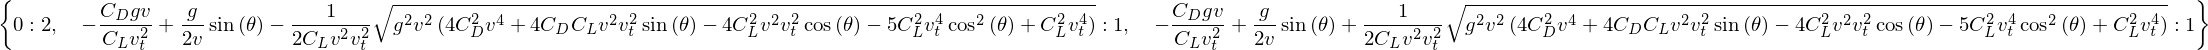

In [73]:
J = f.jacobian(q)
r = J.eigenvals()
r

We can then plug in some of the numbers from the phugoid model to get rid of the constants.

In [74]:
r1 = list(r.keys())[1]
r2 = list(r.keys())[2]
r1=r1.subs([(g, 9.81), (v_t, 30.0), (C_D, 1.0/40.0), (C_L, 1.0)])
r2=r2.subs([(g, 9.81), (v_t, 30.0), (C_D, 1.0/40.0), (C_L, 1.0)])

We'll then assume that $v \simeq v_t$ and plot how the eigenvalue varies with $\theta$.

<IPython.core.display.Javascript object>


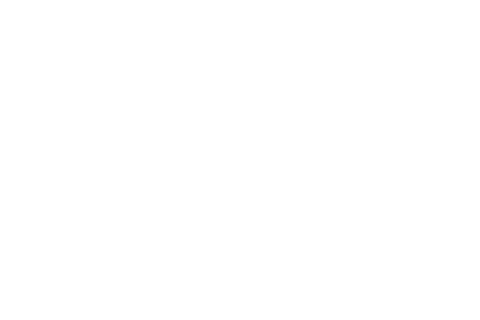

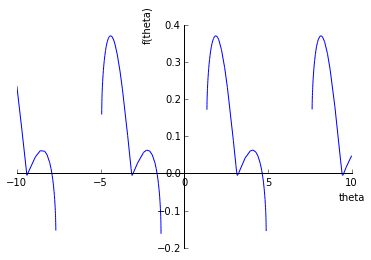

In [75]:
r1 = r1.subs(v, 30.0)
r2 = r2.subs(v, 30.0)
sympy.plot(r1); 

<IPython.core.display.Javascript object>


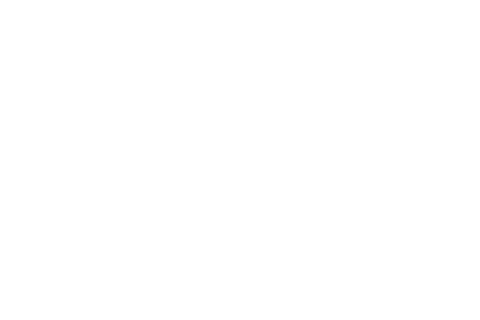

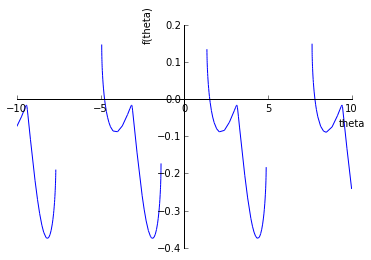

In [76]:
sympy.plot(r2);

In the original simulation we had $h \le 0.1$ So it seems reasonable to assume that $h \lambda \sim {\cal O}(10^{-1})$. On the original phugoid problem we had $X = 100$ so our error bound is probably $\sim \delta \times 10^1 \times e^{0.1 \times 100} \simeq 2 \times 10^{-11}$.

Summarizing this fairly lengthy discussion:

* There will be floating point error leading to a best expected accuracy.
* We can estimate this from the problem and its parameters
* In this case the estimate is ${\cal O}(10^{-11})$, so there is probably no point in trying to do better than $10^{-10}$.

### Stable, consistent

Finally, there's the case where we measure something that is converging, but isn't clearly converging perfectly in line with the analysis. The point here is to be as sure as possible that we're getting something reasonable.

The analysis shows that

$$
\begin{equation}
  D(h) = \alpha h + \beta h^2 + \dots.
\end{equation}
$$

In order to actually measure something, we *assume* that $h$ is sufficiently small that we can ignore all terms except the first. We then model $D$ as $D = \hat{\alpha} h^s$ and measure $\hat{\alpha}$ and $s$. If $s$ is close to one we believe our assumptions were reasonable and say that everything is fine.

Here is the crux of Greg's question. What does "close to one" mean here? How should we interpret our results. With what confidence can we say that the data is consistent with our algorithm being correct?

## Analysis

That was a lot of background. Let's do some back of the envelope calculations to see how bad things can be.

We want to show that our algorithm is behaving as

$$
\begin{equation}
  D(h) = h
\end{equation}
$$

for sufficiently small $h$.

Let's suppose that the algorithm we've implemented actually behaves as

$$
\begin{equation}
  D(h) = 10^{-8} h^{-1} + h + 10^{-8} h^2.
\end{equation}
$$

Over what region would it appear to be behaving "correctly"?

In [77]:
h = numpy.logspace(-14.0, 14.0)
D = 1e-8/h + h + 1e-8*h**2

<IPython.core.display.Javascript object>


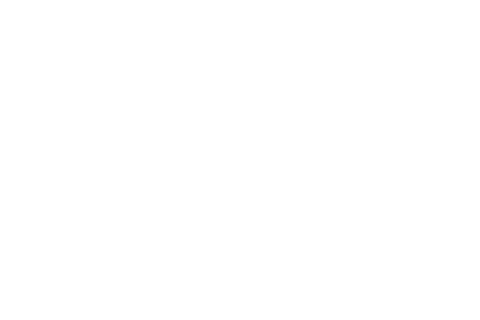

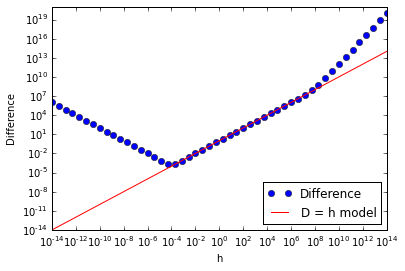

In [78]:
pyplot.loglog(h, D, 'bo', label = 'Difference')
pyplot.loglog(h, h, 'r-', label = 'D = h model')
pyplot.xlabel('h')
pyplot.ylabel('Difference')
pyplot.legend(loc='lower right');

So, despite being *completely inconsistent, and unstable*, the algorithm appears to behave correctly over **12** orders of magnitude: from $h \sim 10^{-4}$ to $h \sim 10^{8}$.

In reality, the behaviour at the top end (large $h$) is not a concern. What's more important is how it behaves for small $h$. 

It's also noticeable that in the convergence check for the phugoid model, the behaviour was only checked over 2 orders of magnitude. So, should we be concerned?

In the original phugoid model notebook the differences were computed over a fairly narrow range of $h$. If we modify that range, we can check the data in more detail.

In [79]:
h_values = numpy.array([0.1*2**(-i) for i in range(-3,18)])
differences = numpy.array([3.70456578e+04,   5.11556903e+02,   2.68347318e+02,
         1.40645139e+02,   7.00473279e+01,   3.51807674e+01,
         1.76241342e+01,   1.15159153e+00,   5.69993649e-01,
         2.83511479e-01,   1.41334800e-01,   7.05107406e-02,
         3.51645549e-02,   1.75078941e-02,   8.68366865e-03,
         4.27258022e-03,   2.06729609e-03,   9.64716814e-04,
         4.13441038e-04,   1.37809468e-04,   0.00000000e+00])

Note that the final value is from the reference solution, so of course there's no information there.

First we plot this on a loglog scale to see if it's roughly correct.

<IPython.core.display.Javascript object>


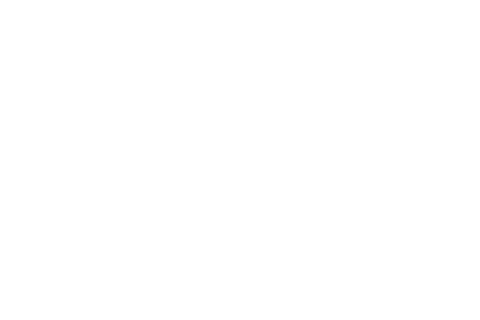

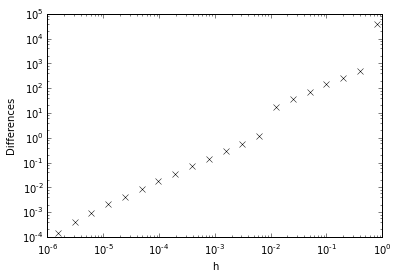

In [80]:
pyplot.loglog(h_values[:-1], differences[:-1], 'kx')
pyplot.xlabel('h')
pyplot.ylabel('Differences');

We see that visually the behaviour looks ok for $h \lt 10^{-2}$. Above that it isn't behaving well. So let's replot, excluding the values of $h$ which don't appear to be "sufficiently small".

<IPython.core.display.Javascript object>


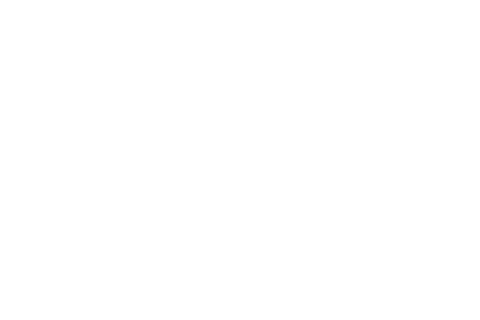

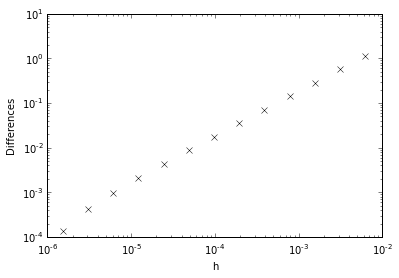

In [81]:
h_small = h_values[numpy.logical_and(h_values < 1e-2, h_values > 1e-6)]
differences_small = differences[numpy.logical_and(h_values < 1e-2, h_values > 1e-6)]
pyplot.loglog(h_small, differences_small, 'kx')
pyplot.xlabel('h')
pyplot.ylabel('Differences');

We now do our standard thing: assume that this is perfectly modelled by $D(h) = a h^s$ and use linear regression (of $\log(D)$ against $\log(h)$) to find the parameters $a$ and $s$. First we'll do this using the entire dataset.

In [82]:
p_all = numpy.polyfit(numpy.log(h_small), numpy.log(differences_small), 1)
print("The measured value of s is {:.3f}".format(p_all[0]))

The measured value of s is 1.052


So this is off by about 5%. Let's plot the line of best fit and see where the difference lies.

<IPython.core.display.Javascript object>


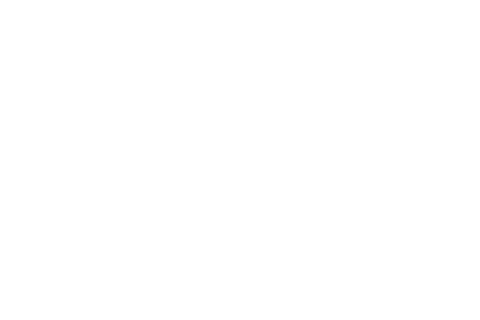

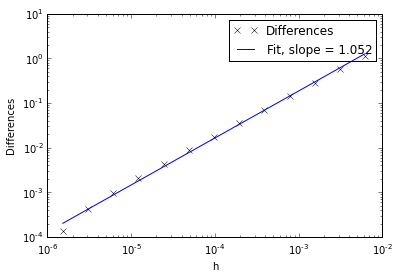

In [83]:
pyplot.loglog(h_small, differences_small, 'kx', label = 'Differences')
pyplot.loglog(h_small, numpy.exp(p_all[1])*h_small**p_all[0], 'b-', label = "Fit, slope = {:.3f}".format(p_all[0]))
pyplot.legend()
pyplot.xlabel('h')
pyplot.ylabel('Differences');

This is a bit concerning: why isn't the data appearing to get better? Let's try doing the fit for all possible sets of four consecutive points.

In [84]:
for start in range(len(h_small)-4):
    p_fourpoints = numpy.polyfit(numpy.log(h_small[start:start+4]), numpy.log(differences_small[start:start+4]), 1)
    print("Measured value starting from point {} is {:.3f}".format(start, p_fourpoints[0]))

Measured value starting from point 0 is 1.009
Measured value starting from point 1 is 1.005
Measured value starting from point 2 is 1.004
Measured value starting from point 3 is 1.004
Measured value starting from point 4 is 1.007
Measured value starting from point 5 is 1.013
Measured value starting from point 6 is 1.027
Measured value starting from point 7 is 1.056
Measured value starting from point 8 is 1.121


So we get pretty good values at low resolutions: at high resolutions something odd is happening.

# More terms

In [85]:
ks = numpy.arange(6)
hs = 2.0**(-4-ks)
y = numpy.zeros(len(ks))
for i, h in enumerate(hs):
    y[i] = 1.0 + 0.1*h+0.2*h**2

In [86]:
alpha = numpy.zeros_like(y)
for i in range(len(y)-1):
    alpha[i] = y[i+1]-y[i]

a_coeff = alpha[0]*alpha[2]-alpha[1]**2
b_coeff = alpha[1]*alpha[2]-alpha[0]*alpha[3]
c_coeff = alpha[1]*alpha[3] - alpha[2]**2

sol_plus = (-b_coeff + numpy.sqrt(b_coeff**2-4.0*a_coeff*c_coeff))/(2.0*a_coeff)
sol_minus = (-b_coeff - numpy.sqrt(b_coeff**2-4.0*a_coeff*c_coeff))/(2.0*a_coeff)

print("Two solutions are {} and {}".format(-numpy.log2(sol_plus), -numpy.log2(sol_minus)))

Two solutions are 0.99999999999764 and 1.999999999962835
